In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import sys
import os
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from xgboost import XGBRegressor, callback
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error

sys.path.append(os.path.abspath(".."))

from src.feature_engineering import make_XY_val, make_train_fast, make_X_test


In [2]:
BASE = Path("../data/processed")
CLUSTERS_PATH = BASE.parent / "clusters" / "cluster_labels_k4.csv"
X_tr = pd.read_csv(BASE / "X_train.csv", index_col=0,parse_dates=True)
Y_tr = pd.read_csv(BASE / "y_train.csv", index_col=0,parse_dates=True)
clusters_labels = pd.read_csv(CLUSTERS_PATH, index_col=0)

In [3]:
holed_cols = [col for col in X_tr.columns if col.startswith("holed_")]
clean_cols = [col for col in X_tr.columns if col not in holed_cols]

In [4]:
X_val, Y_val = make_XY_val(X_tr,Y_tr,holed_cols,n_lags=3, n_leads=0,rolling_windows=[3,6,12,24])
X_train = make_train_fast(X_tr,clean_cols,n_samples = 20000,n_lags=3,n_leads=0,rolling_windows=[3,6,12,24])

Création de X_val enrichi: 100%|██████████| 953/953 [02:22<00:00,  6.70it/s]


X_val : 123,149 lignes | 31 features
 Préparation des positions valides...


Scan des colonnes propres: 100%|██████████| 19229/19229 [00:02<00:00, 6518.78it/s]



 20,325,053 valeurs disponibles pour tirage aléatoire.

 Construction du dataset d'entraînement enrichi...


Création des lignes: 100%|██████████| 20000/20000 [00:18<00:00, 1056.75it/s]



 Jeu d'entraînement enrichi créé : 20,000 lignes × 34 colonnes


In [134]:
X_val.columns
X_train.columns

Index(['col', 'weekday', 'isweekend', 'hour', 'hour_sin', 'hour_cos', 'mean',
       'std', 'range', 'std_rel', 'profile_hour_mean', 'y', 'trend_12h',
       'slope_6h', 'lag_1', 'lag_2', 'lag_3', 'delta_lag_1', 'delta_lead_1',
       'rolling_mean_3h', 'rolling_std_3h', 'rolling_stability_3h',
       'rolling_mean_6h', 'rolling_std_6h', 'rolling_stability_6h',
       'rolling_mean_12h', 'rolling_std_12h', 'rolling_stability_12h',
       'rolling_mean_24h', 'rolling_std_24h', 'rolling_stability_24h',
       'local_mean', 'local_std', 'slope_6h_rel'],
      dtype='object')

## 1. On entraîne avec toutes les features

In [5]:
X_v = X_val.copy()
X_t = X_train.copy()
y_v = Y_val.copy()
y_t = X_train['y'].copy()

In [6]:
col_to_drop_v = ['col']
col_to_drop_t = ['col','local_mean', 'local_std','y']

In [7]:
X_v.drop(columns=col_to_drop_v, inplace=True)
X_t.drop(columns=col_to_drop_t, inplace=True)

In [8]:
model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.01,
    num_leaves=80,             # limite la profondeur réelle
    min_data_in_leaf=300,      # empêche les splits sur peu de points
    reg_alpha=20,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
)

model.fit(X_t, y_t.values)
y_pred_train = model.predict(X_t)
mae_train = mean_absolute_error(y_t.values, y_pred_train)
print(f" MAE train LGBMRegressor = {mae_train:.4f}")
y_pred = model.predict(X_v)
mae = mean_absolute_error(y_v.y_true.values, y_pred)
print(f" MAE val LGBM) = {mae:.4f}")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6252
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 29
[LightGBM] [Info] Start training from score 5.032013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [9]:
y_v_denorm = np.expm1(y_v.y_true.values)
y_pred_denorm = np.expm1(y_pred)
print(mean_absolute_error(y_v_denorm, y_pred_denorm))

118.8585359640576


MAE : 46.6171 sur le train et 108.7086 sur la validation.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

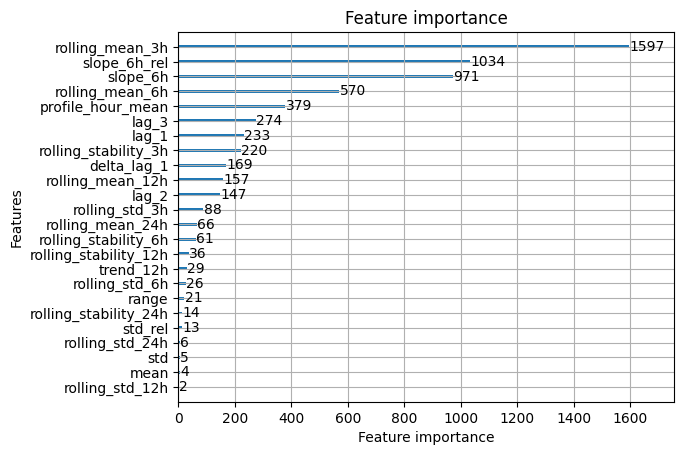

In [142]:
plot_importance(model, max_num_features=32)

## On entraîne avec moins de features sur le train et le val

In [24]:
X_v = X_val.copy()
X_t = X_train.copy()
y_v = Y_val.copy()
y_t = X_train['y'].copy()

In [26]:
col_to_drop_v = ['col','delta_lag_1','mean', 'std', 'range', 'std_rel', 'weekday', 'isweekend',
       'hour', 'hour_sin', 'hour_cos', 'profile_hour_mean', 'trend_12h','rolling_mean_12h', 'rolling_std_12h', 'rolling_stability_12h',
       'rolling_mean_24h', 'rolling_std_24h', 'rolling_stability_24h']
col_to_drop_t = ['col','local_mean', 'local_std','y','delta_lag_1','mean', 'std', 'range', 'std_rel', 'weekday', 'isweekend',
       'hour', 'hour_sin', 'hour_cos', 'profile_hour_mean', 'trend_12h','rolling_mean_12h', 'rolling_std_12h', 'rolling_stability_12h',
       'rolling_mean_24h', 'rolling_std_24h', 'rolling_stability_24h']

In [27]:
X_v.drop(columns=col_to_drop_v, inplace=True)
X_t.drop(columns=col_to_drop_t, inplace=True)

In [28]:
model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.01,
    num_leaves=80,             # limite la profondeur réelle
    min_data_in_leaf=300,      # empêche les splits sur peu de points
    reg_alpha=20,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
)

model.fit(X_t, y_t.values)
y_pred_train = model.predict(X_t)
mae_train = mean_absolute_error(y_t.values, y_pred_train)
print(f" MAE train LGBMRegressor = {mae_train:.4f}")
y_pred = model.predict(X_v)
mae = mean_absolute_error(y_v.y_true.values, y_pred)
print(f" MAE val LGBM) = {mae:.4f}")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,007069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 11
[LightGBM] [Info] Start training from score 353,996650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

MAE : 47.2303 sur le train et 110.1242 sur la validation.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

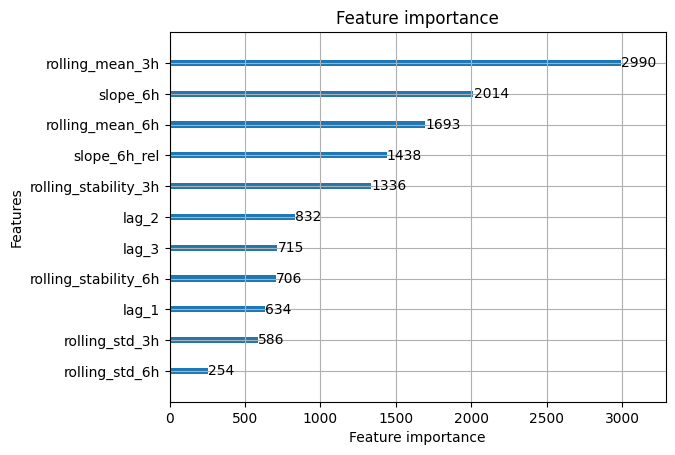

In [29]:
plot_importance(model, max_num_features=32)

## On rajoute le cluster

In [143]:
X_v = X_val.copy()
X_t = X_train.copy()
y_v = Y_val.copy()
y_t = X_train['y'].copy()

In [144]:
X_t["cluster"] = X_t["col"].map(clusters_labels["cluster"])
X_v["cluster"] = X_v["col"].map(clusters_labels["cluster"])

In [145]:
col_to_drop_v = ['col','delta_lag_1','delta_lead_1','mean', 'std', 'range', 'std_rel', 'weekday', 'isweekend',
       'hour', 'hour_sin', 'hour_cos', 'profile_hour_mean', 'trend_12h','rolling_mean_12h', 'rolling_std_12h', 'rolling_stability_12h',
       'rolling_mean_24h', 'rolling_std_24h', 'rolling_stability_24h']
col_to_drop_t = ['col','local_mean', 'local_std','y','delta_lag_1','delta_lead_1','mean', 'std', 'range', 'std_rel', 'weekday', 'isweekend',
       'hour', 'hour_sin', 'hour_cos', 'profile_hour_mean', 'trend_12h','rolling_mean_12h', 'rolling_std_12h', 'rolling_stability_12h',
       'rolling_mean_24h', 'rolling_std_24h', 'rolling_stability_24h']

In [146]:
X_v.drop(columns=col_to_drop_v, inplace=True)
X_t.drop(columns=col_to_drop_t, inplace=True)

In [147]:
model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.01,
    num_leaves=80,             # limite la profondeur réelle
    min_data_in_leaf=300,      # empêche les splits sur peu de points
    reg_alpha=20,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
)

model.fit(X_t, y_t.values)
y_pred_train = model.predict(X_t)
mae_train = mean_absolute_error(y_t.values, y_pred_train)
print(f" MAE train LGBMRegressor = {mae_train:.4f}")
y_pred = model.predict(X_v)
mae = mean_absolute_error(y_v.y_true.values, y_pred)
print(f" MAE val LGBM) = {mae:.4f}")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2809
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 12
[LightGBM] [Info] Start training from score 4,860317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

MAE : 47.3115 sur le train et 110.1659 sur la validation.

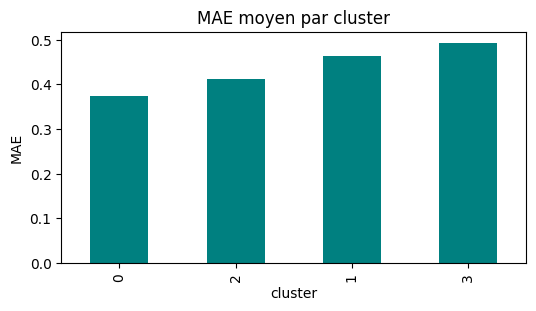

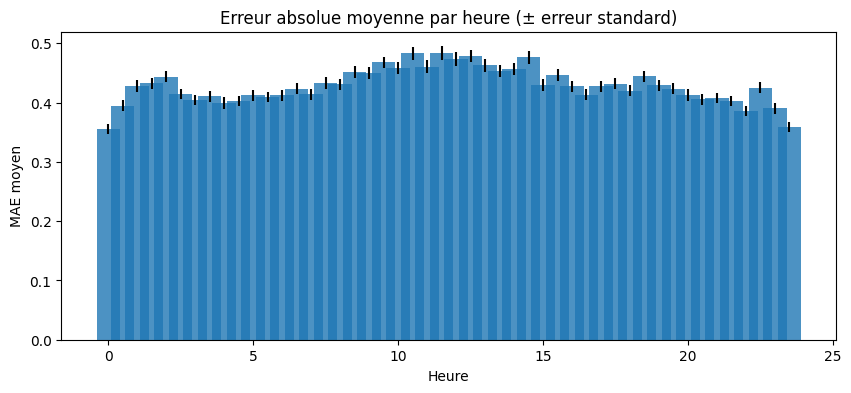

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\1145104994.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_mae.index, y=weekday_mae.values, palette="viridis")


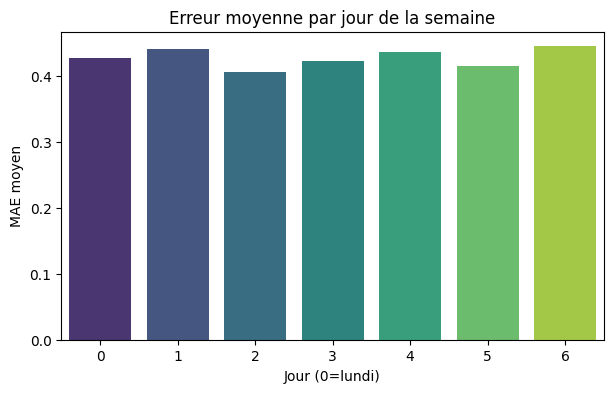

In [148]:
# === Création d’un DataFrame des prédictions ===
df_eval = X_v.copy()
df_eval['y_true'] = y_v.y_true.values
df_eval['y_pred'] = y_pred
df_eval['abs_error'] = (df_eval['y_true'] - df_eval['y_pred']).abs()
df_eval['hour'] = X_val['hour']
df_eval['weekday'] = X_val['weekday']



# === MAE global par cluster ===
mae_cluster = df_eval.groupby("cluster")["abs_error"].mean().sort_values()
plt.figure(figsize=(6,3))
mae_cluster.plot(kind="bar", color="teal")
plt.title("MAE moyen par cluster")
plt.ylabel("MAE")
plt.show()

# === MAE par heure ===
plt.figure(figsize=(10,4))
hourly_mae = df_eval.groupby("hour")["abs_error"].agg(['mean', 'sem'])
plt.bar(hourly_mae.index, hourly_mae['mean'], yerr=hourly_mae['sem'], alpha=0.8)
plt.title("Erreur absolue moyenne par heure (± erreur standard)")
plt.xlabel("Heure")
plt.ylabel("MAE moyen")
plt.show()

# === MAE par jour de la semaine ===
plt.figure(figsize=(7,4))
weekday_mae = df_eval.groupby("weekday")["abs_error"].mean()
sns.barplot(x=weekday_mae.index, y=weekday_mae.values, palette="viridis")
plt.title("Erreur moyenne par jour de la semaine")
plt.xlabel("Jour (0=lundi)")
plt.ylabel("MAE moyen")
plt.show()

## On entraîne le modèle uniquement sur la première semaine pour voir ce que l'on obtient

In [53]:
end_week1 = '2023-01-17 00:00'
X_tr_w1 = X_tr[X_tr.index < end_week1]
Y_tr_w1 = Y_tr[Y_tr.index < end_week1]

In [54]:
X_val, Y_val = make_XY_val(X_tr_w1,Y_tr_w1,holed_cols,n_lags=3, n_leads=0,rolling_windows=[3,6,12,24,48])
X_train = make_train_fast(X_tr_w1,clean_cols,n_samples = 20000,n_lags=3,n_leads=0,rolling_windows=[3,6,12,24,48])

Création de X_val enrichi: 100%|██████████| 999/999 [01:16<00:00, 13.10it/s]


X_val : 45,327 lignes | 34 features
 Préparation des positions valides...


Scan des colonnes propres: 100%|██████████| 18844/18844 [00:02<00:00, 7141.94it/s]



 7,236,096 valeurs disponibles pour tirage aléatoire.

 Construction du dataset d'entraînement enrichi...


Création des lignes: 100%|██████████| 20000/20000 [00:31<00:00, 642.51it/s]



 Jeu d'entraînement enrichi créé : 20,000 lignes × 37 colonnes


In [55]:
col_to_drop_v = ['col','delta_lag_1','delta_lead_1','mean', 'std', 'range', 'std_rel', 'weekday', 'isweekend',
       'hour', 'hour_sin', 'hour_cos', 'profile_hour_mean', 'trend_12h','rolling_mean_12h', 'rolling_std_12h', 'rolling_stability_12h',
       'rolling_mean_24h', 'rolling_std_24h', 'rolling_stability_24h']
col_to_drop_t = ['col','local_mean', 'local_std','y','delta_lag_1','delta_lead_1','mean', 'std', 'range', 'std_rel', 'weekday', 'isweekend',
       'hour', 'hour_sin', 'hour_cos', 'profile_hour_mean', 'trend_12h','rolling_mean_12h', 'rolling_std_12h', 'rolling_stability_12h',
       'rolling_mean_24h', 'rolling_std_24h', 'rolling_stability_24h']

In [59]:
X_v = X_val.copy()
X_t = X_train.copy()
y_v = Y_val.copy()
y_t = X_train['y'].copy()

In [60]:
X_t["cluster"] = X_t["col"].map(clusters_labels["cluster"])
X_v["cluster"] = X_v["col"].map(clusters_labels["cluster"])

In [61]:
X_v.drop(columns=col_to_drop_v, inplace=True)
X_t.drop(columns=col_to_drop_t, inplace=True)

In [66]:
model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.01,
    num_leaves=80,             # limite la profondeur réelle
    min_data_in_leaf=300,      # empêche les splits sur peu de points
    reg_alpha=20,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
)

model.fit(X_t, y_t.values)
y_pred_train = model.predict(X_t)
mae_train = mean_absolute_error(y_t.values, y_pred_train)
print(f" MAE train LGBMRegressor = {mae_train:.4f}")
y_pred = model.predict(X_v)
mae = mean_absolute_error(y_v.y_true.values, y_pred)
print(f" MAE val LGBM) = {mae:.4f}")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 15
[LightGBM] [Info] Start training from score 300,024900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

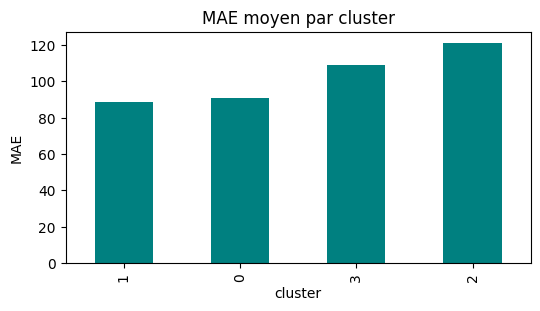

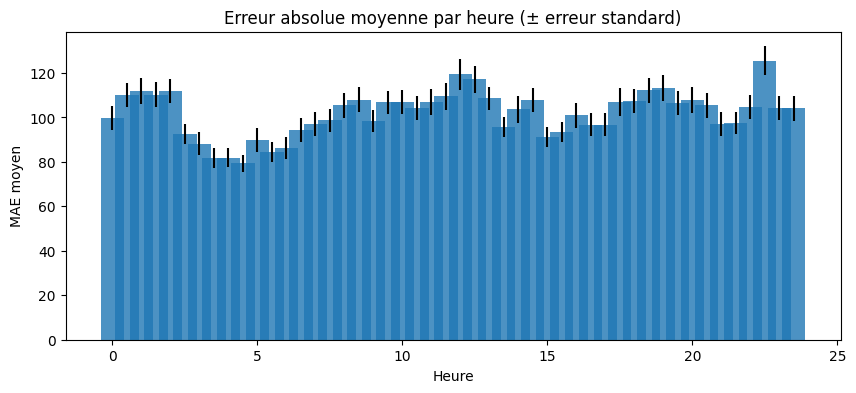

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\1145104994.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_mae.index, y=weekday_mae.values, palette="viridis")


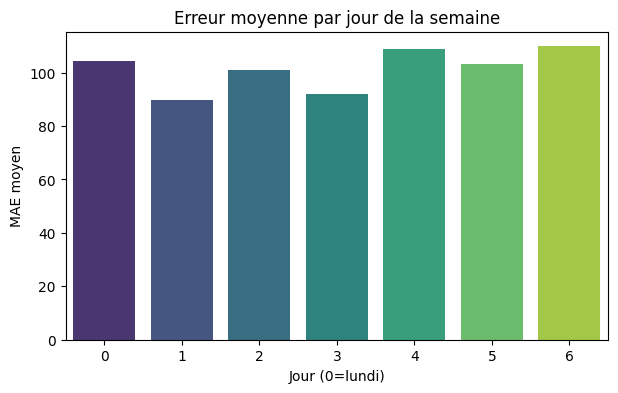

In [63]:
# === Création d’un DataFrame des prédictions ===
df_eval = X_v.copy()
df_eval['y_true'] = y_v.y_true.values
df_eval['y_pred'] = y_pred
df_eval['abs_error'] = (df_eval['y_true'] - df_eval['y_pred']).abs()
df_eval['hour'] = X_val['hour']
df_eval['weekday'] = X_val['weekday']



# === MAE global par cluster ===
mae_cluster = df_eval.groupby("cluster")["abs_error"].mean().sort_values()
plt.figure(figsize=(6,3))
mae_cluster.plot(kind="bar", color="teal")
plt.title("MAE moyen par cluster")
plt.ylabel("MAE")
plt.show()

# === MAE par heure ===
plt.figure(figsize=(10,4))
hourly_mae = df_eval.groupby("hour")["abs_error"].agg(['mean', 'sem'])
plt.bar(hourly_mae.index, hourly_mae['mean'], yerr=hourly_mae['sem'], alpha=0.8)
plt.title("Erreur absolue moyenne par heure (± erreur standard)")
plt.xlabel("Heure")
plt.ylabel("MAE moyen")
plt.show()

# === MAE par jour de la semaine ===
plt.figure(figsize=(7,4))
weekday_mae = df_eval.groupby("weekday")["abs_error"].mean()
sns.barplot(x=weekday_mae.index, y=weekday_mae.values, palette="viridis")
plt.title("Erreur moyenne par jour de la semaine")
plt.xlabel("Jour (0=lundi)")
plt.ylabel("MAE moyen")
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

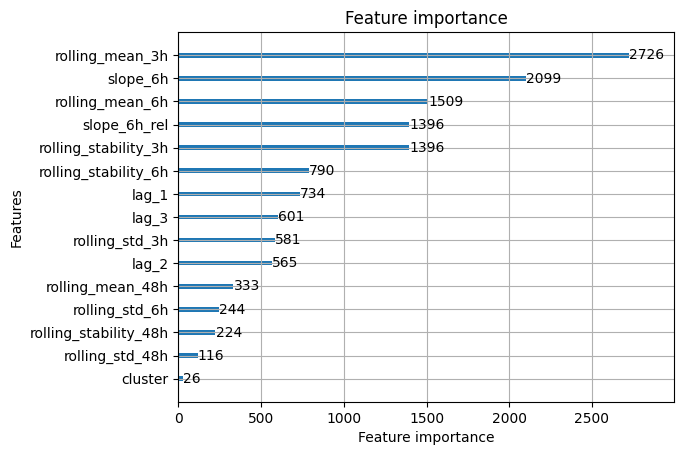

In [67]:
plot_importance(model)

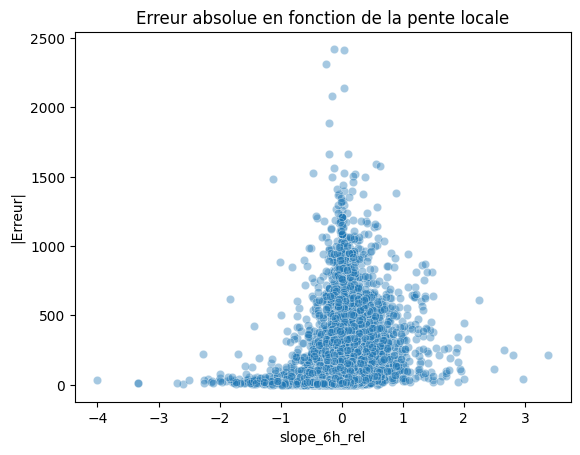

In [70]:
plot_df = X_v.copy()
plot_df = plot_df.reset_index(drop=True)
plot_df["abs_error"] = np.abs(y_v.y_true.values - y_pred)

sns.scatterplot(data=plot_df, x="slope_6h_rel", y="abs_error", alpha=0.4)
plt.title("Erreur absolue en fonction de la pente locale")
plt.xlabel("slope_6h_rel")
plt.ylabel("|Erreur|")
plt.show()

### On essaye d'enrichir les features

In [126]:
X_v = X_val.copy()
X_t = X_train.copy()
y_v = Y_val.copy()
y_t = X_train['y'].copy()


In [127]:
X_t["zscore_col"] = (X_t["rolling_mean_6h"] - X_t["mean"]) / (X_t["std"] + 1e-6)
X_v["zscore_col"] = (X_v["rolling_mean_6h"] - X_v["mean"]) / (X_v["std"] + 1e-6)
X_t["trend_48h"] = X_t["rolling_mean_6h"] - X_t["rolling_mean_48h"]
X_v["trend_48h"] = X_v["rolling_mean_6h"] - X_v["rolling_mean_48h"]
X_t["slope_x_level"] = X_t["slope_6h"] * X_t["rolling_mean_6h"]
X_v["slope_x_level"] = X_v["slope_6h"] * X_v["rolling_mean_6h"]

# --- 1️⃣ Pentes longues ---
X_t["slope_12h"] = X_t["rolling_mean_6h"] - X_t["rolling_mean_12h"]
X_t["slope_24h"] = X_t["rolling_mean_12h"] - X_t["rolling_mean_48h"]

X_v["slope_12h"] = X_v["rolling_mean_6h"] - X_v["rolling_mean_12h"]
X_v["slope_24h"] = X_v["rolling_mean_12h"] - X_v["rolling_mean_48h"]

# --- 2️⃣ Accélération (variation de pente) ---
X_t["accel_6h"] = X_t["slope_6h"] - X_t["slope_12h"]
X_v["accel_6h"] = X_v["slope_6h"] - X_v["slope_12h"]

# --- 3️⃣ Volatilité relative ---
X_t["volatility_ratio"] = (X_t["rolling_std_6h"] / (X_t["rolling_mean_6h"].abs() + 1e-6))
X_v["volatility_ratio"] = (X_v["rolling_std_6h"] / (X_v["rolling_mean_6h"].abs() + 1e-6))




In [128]:
X_v.drop(columns=col_to_drop_v, inplace=True)
X_t.drop(columns=col_to_drop_t, inplace=True)

In [123]:
import optuna
from sklearn.model_selection import TimeSeriesSplit

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 500),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state": 42,
        "n_jobs": -1
    }

    model = LGBMRegressor(**params)
    tscv = TimeSeriesSplit(n_splits=3)
    maes = []

    for train_idx, val_idx in tscv.split(X_t):
        X_train_fold, X_val_fold = X_t.iloc[train_idx], X_v.iloc[val_idx]
        y_train_fold, y_val_fold = X_t.iloc[train_idx]["y"], y_v.iloc[val_idx]
        X_val_fold.drop(columns=col_to_drop_v, inplace=True)
        X_train_fold.drop(columns=col_to_drop_t, inplace=True)
        model.fit(X_train_fold, y_train_fold.values)
        y_pred = model.predict(X_val_fold)
        maes.append(mean_absolute_error(y_val_fold.y_true.values, y_pred))

    return np.mean(maes)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("Best params:", study.best_params)
print("Best MAE:", study.best_value)

[I 2025-11-13 15:26:59,281] A new study created in memory with name: no-name-06e548a7-608b-4844-a26a-0a7ae816cf50
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=402, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=402
[LightGBM] [Warning] min_data_in_leaf is set=402, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:03,019] Trial 0 finished with value: 105.9366397146576 and parameters: {'n_estimators': 823, 'learning_rate': 0.015422456651308135, 'num_leaves': 189, 'min_data_in_leaf': 402, 'reg_alpha': 2.7379447520876834, 'reg_lambda': 7.092147658590341, 'subsample': 0.8700200779486658, 'colsample_bytree': 0.7243228119490761}. Best is trial 0 with value: 105.9366397146576.


[LightGBM] [Warning] min_data_in_leaf is set=402, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=402
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,002876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:09,120] Trial 1 finished with value: 107.7757313884988 and parameters: {'n_estimators': 739, 'learning_rate': 0.020967347018003953, 'num_leaves': 182, 'min_data_in_leaf': 220, 'reg_alpha': 4.90561144654468, 'reg_lambda': 9.356542261166428, 'subsample': 0.9442967992027329, 'colsample_bytree': 0.7342562417208871}. Best is trial 0 with value: 105.9366397146576.


[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] min_data_in_leaf is set=462, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=462
[LightGBM] [Warning] min_data_in_leaf is set=462, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=462
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=462, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=462
[LightGBM] [Warning] min_data_in_leaf is set=462, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=462
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 21
[LightGBM] [Info] Start training from score 302,408200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-11-13 15:27:10,948] Trial 2 finished with value: 104.71549081240545 and parameters: {'n_estimators': 468, 'learning_rate': 0.07023557541318835, 'num_leaves': 181, 'min_data_in_leaf': 462, 'reg_alpha': 0.6822301083365423, 'reg_lambda': 7.4353454216955015, 'subsample': 0.9432415629631895, 'colsample_bytree': 0.698234473856046}. Best is trial 2 with value: 104.71549081240545.
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 21
[LightGBM] [Info] Start training from score 302,408200


C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)
[I 2025-11-13 15:27:16,120] Trial 3 finished with value: 107.81957850023541 and parameters: {'n_estimators': 654, 'learning_rate': 0.12542215643580626, 'num_leaves': 77, 'min_data_in_leaf': 64, 'reg_alpha': 6.169741226510499, 'reg_lambda': 0.8339717471027319, 'subsample': 0.6832889669889148,

[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] min_data_in_leaf is set=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] min_data_in_leaf is set=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 21
[LightGBM] [Info] Start training from score 305,393400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:20,848] Trial 4 finished with value: 114.50396285012147 and parameters: {'n_estimators': 933, 'learning_rate': 0.16336875102563927, 'num_leaves': 186, 'min_data_in_leaf': 178, 'reg_alpha': 9.969047818270708, 'reg_lambda': 7.567464128619157, 'subsample': 0.812089906622198, 'colsample_bytree': 0.749626648172434}. Best is trial 2 with value: 104.71549081240545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 21
[LightGBM] [Info] Start training from score 302,408200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-13 15:27:29,273] Trial 5 finished with value: 107.37467044995951 and parameters: {'n_estimators': 425, 'learning_rate': 0.13923046139557438, 'num_leaves': 92, 'min_data_in_leaf': 65, 'reg_alpha': 5.5861595812009295, 'reg_lambda': 8.405241068607058, 'subsample': 0.7593648221607348, 'colsample_bytree': 0.5621730340597901}. Best is trial 2 with value: 104.71549081240545.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=423, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=423
[LightGBM] [Warning] min_data_in_leaf is set=423, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=423, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=423
[LightGBM] [Warning] min_data_in_leaf is set=423, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 21
[LightGBM] [Info] Start training from score 305,393400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:32,935] Trial 6 finished with value: 104.80012783233853 and parameters: {'n_estimators': 918, 'learning_rate': 0.04461575833807557, 'num_leaves': 167, 'min_data_in_leaf': 423, 'reg_alpha': 6.579070879055635, 'reg_lambda': 8.289768998345027, 'subsample': 0.5591254031813977, 'colsample_bytree': 0.6941186088913863}. Best is trial 2 with value: 104.71549081240545.


[LightGBM] [Warning] min_data_in_leaf is set=423, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=423
[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:35,241] Trial 7 finished with value: 105.64954542995872 and parameters: {'n_estimators': 388, 'learning_rate': 0.021186714637416896, 'num_leaves': 120, 'min_data_in_leaf': 138, 'reg_alpha': 9.375265126107607, 'reg_lambda': 3.157699959399646, 'subsample': 0.8116667263378983, 'colsample_bytree': 0.5072945725550482}. Best is trial 2 with value: 104.71549081240545.


[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Warning] min_data_in_leaf is set=158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=158
[LightGBM] [Warning] min_data_in_leaf is set=158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:37,783] Trial 8 finished with value: 106.25765284983372 and parameters: {'n_estimators': 541, 'learning_rate': 0.010505771860913124, 'num_leaves': 66, 'min_data_in_leaf': 158, 'reg_alpha': 7.279151156500088, 'reg_lambda': 4.138421237154053, 'subsample': 0.6924107116824947, 'colsample_bytree': 0.7796398778200115}. Best is trial 2 with value: 104.71549081240545.


[LightGBM] [Warning] min_data_in_leaf is set=158, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=158
[LightGBM] [Warning] min_data_in_leaf is set=433, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=433
[LightGBM] [Warning] min_data_in_leaf is set=433, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:39,527] Trial 9 finished with value: 107.08111591980862 and parameters: {'n_estimators': 678, 'learning_rate': 0.15890914888741153, 'num_leaves': 167, 'min_data_in_leaf': 433, 'reg_alpha': 2.993703034168187, 'reg_lambda': 4.539078563613835, 'subsample': 0.7795216639573066, 'colsample_bytree': 0.9598256519349365}. Best is trial 2 with value: 104.71549081240545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

[LightGBM] [Warning] min_data_in_leaf is set=331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=331
[LightGBM] [Warning] min_data_in_leaf is set=331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)
[I 2025-11-13 15:27:40,365] Trial 10 finished with value: 109.02380683748724 and parameters: {'n_estimators': 236, 'learning_rate': 0.05766226029145239, 'num_leaves': 33, 'min_data_in_leaf': 331, 'reg_alpha': 0.08468090134410655, 'reg_lambda': 6.143060796334065, 'subsample': 0.99807118926473

[LightGBM] [Warning] min_data_in_leaf is set=331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=331
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 21
[LightGBM] [Info] Start training from score 305,393400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 21
[LightGBM] [Info] Start training from score 302,408200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-11-13 15:27:43,590] Trial 11 finished with value: 105.25739961540974 and parameters: {'n_estimators': 993, 'learning_rate': 0.053126639465449516, 'num_leaves': 133, 'min_data_in_leaf': 500, 'reg_alpha': 0.7438397192505057, 'reg_lambda': 9.371742015434666, 'subsample': 0.5153851109037695, 'colsample_bytree': 0.621670502394821}. Best is trial 2 with value: 104.71549081240545.
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

[LightGBM] [Warning] min_data_in_leaf is set=331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=331
[LightGBM] [Warning] min_data_in_leaf is set=331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,002002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:47,626] Trial 12 finished with value: 108.85681469399225 and parameters: {'n_estimators': 515, 'learning_rate': 0.07956095736419942, 'num_leaves': 150, 'min_data_in_leaf': 331, 'reg_alpha': 7.989978409436835, 'reg_lambda': 6.168961127997585, 'subsample': 0.5201197047329484, 'colsample_bytree': 0.6538847313099044}. Best is trial 2 with value: 104.71549081240545.
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[LightGBM] [Warning] min_data_in_leaf is set=496, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=496
[LightGBM] [Warning] min_data_in_leaf is set=496, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=496, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=496
[LightGBM] [Warning] min_data_in_leaf is set=496, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 21
[LightGBM] [Info] Start training from score 305,393400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=496, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=496
[LightGBM] [Warning] min_data_in_leaf is set=496, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 21
[LightGBM] [Info] Start training from score 302,408200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-11-13 15:27:50,606] Trial 13 finished with value: 105.33313173091851 and parameters: {'n_estimators': 844, 'learning_rate': 0.033321625411041944, 'num_leaves': 153, 'min_data_in_leaf': 496, 'reg_alpha': 3.603701775543721, 'reg_lambda': 7.932357621811441, 'subsample': 0.6185538619627627, 'colsample_bytree': 0.8469102643531143}. Best is trial 2 with value: 104.71549081240545.
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

[LightGBM] [Warning] min_data_in_leaf is set=401, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=401
[LightGBM] [Warning] min_data_in_leaf is set=401, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:51,429] Trial 14 finished with value: 105.38589564940129 and parameters: {'n_estimators': 202, 'learning_rate': 0.0854733690806274, 'num_leaves': 138, 'min_data_in_leaf': 401, 'reg_alpha': 4.235300889562416, 'reg_lambda': 6.118896723424809, 'subsample': 0.6299692992236063, 'colsample_bytree': 0.6485273550716547}. Best is trial 2 with value: 104.71549081240545.
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

[LightGBM] [Warning] min_data_in_leaf is set=312, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=312
[LightGBM] [Warning] min_data_in_leaf is set=312, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:52,959] Trial 15 finished with value: 107.74178317936783 and parameters: {'n_estimators': 338, 'learning_rate': 0.035816042708604064, 'num_leaves': 196, 'min_data_in_leaf': 312, 'reg_alpha': 1.7194205371690257, 'reg_lambda': 9.940217634224178, 'subsample': 0.8753318603487003, 'colsample_bytree': 0.6766489592027702}. Best is trial 2 with value: 104.71549081240545.


[LightGBM] [Warning] min_data_in_leaf is set=312, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=312
[LightGBM] [Warning] min_data_in_leaf is set=447, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=447
[LightGBM] [Warning] min_data_in_leaf is set=447, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=447
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,003406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:54,603] Trial 16 finished with value: 104.39953649867896 and parameters: {'n_estimators': 502, 'learning_rate': 0.08291291464264795, 'num_leaves': 165, 'min_data_in_leaf': 447, 'reg_alpha': 6.801373260721826, 'reg_lambda': 2.2148278091218447, 'subsample': 0.5725825147205004, 'colsample_bytree': 0.8302585467500645}. Best is trial 16 with value: 104.39953649867896.
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

[LightGBM] [Warning] min_data_in_leaf is set=452, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=452
[LightGBM] [Warning] min_data_in_leaf is set=452, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:56,021] Trial 17 finished with value: 104.8593478741116 and parameters: {'n_estimators': 495, 'learning_rate': 0.0936489127494169, 'num_leaves': 118, 'min_data_in_leaf': 452, 'reg_alpha': 8.457924648361406, 'reg_lambda': 1.7105113857958418, 'subsample': 0.9134953378445014, 'colsample_bytree': 0.8368575092486293}. Best is trial 16 with value: 104.39953649867896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:57,005] Trial 18 finished with value: 104.05024788735426 and parameters: {'n_estimators': 305, 'learning_rate': 0.07119872142347664, 'num_leaves': 162, 'min_data_in_leaf': 367, 'reg_alpha': 1.380295704086096, 'reg_lambda': 2.6959886750709927, 'subsample': 0.6928778583008928, 'colsample_bytree': 0.9923368937826473}. Best is trial 18 with value: 104.05024788735426.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:27:58,199] Trial 19 finished with value: 106.74715793941617 and parameters: {'n_estimators': 295, 'learning_rate': 0.11616211151750426, 'num_leaves': 99, 'min_data_in_leaf': 285, 'reg_alpha': 1.992085453983873, 'reg_lambda': 2.4027734999823864, 'subsample': 0.6069023408020444, 'colsample_bytree': 0.9842320866608971}. Best is trial 18 with value: 104.05024788735426.
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

[LightGBM] [Warning] min_data_in_leaf is set=366, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=366
[LightGBM] [Warning] min_data_in_leaf is set=366, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=366, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=366
[LightGBM] [Warning] min_data_in_leaf is set=366, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 21
[LightGBM] [Info] Start training from score 302,408200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-11-13 15:28:00,089] Trial 20 finished with value: 106.87585307723931 and parameters: {'n_estimators': 606, 'learning_rate': 0.1955867953977652, 'num_leaves': 163, 'min_data_in_leaf': 366, 'reg_alpha': 4.5687777788309685, 'reg_lambda': 0.024286595005489797, 'subsample': 0.6958668799372077, 'colsample_bytree': 0.9290214964154453}. Best is trial 18 with value: 104.05024788735426.
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

[LightGBM] [Warning] min_data_in_leaf is set=375, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=375
[LightGBM] [Warning] min_data_in_leaf is set=375, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=375, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=375
[LightGBM] [Warning] min_data_in_leaf is set=375, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 21
[LightGBM] [Info] Start training from score 305,393400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:28:01,403] Trial 21 finished with value: 105.51695722913588 and parameters: {'n_estimators': 443, 'learning_rate': 0.06831786723930805, 'num_leaves': 174, 'min_data_in_leaf': 375, 'reg_alpha': 1.214948434992873, 'reg_lambda': 3.1849111348223844, 'subsample': 0.5772624865364347, 'colsample_bytree': 0.8175448456775838}. Best is trial 18 with value: 104.05024788735426.
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

[LightGBM] [Warning] min_data_in_leaf is set=464, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=464
[LightGBM] [Warning] min_data_in_leaf is set=464, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=464, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=464
[LightGBM] [Warning] min_data_in_leaf is set=464, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 21
[LightGBM] [Info] Start training from score 305,393400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:28:02,349] Trial 22 finished with value: 105.53907295736121 and parameters: {'n_estimators': 332, 'learning_rate': 0.10134345495619672, 'num_leaves': 136, 'min_data_in_leaf': 464, 'reg_alpha': 0.31202389040548295, 'reg_lambda': 1.7251871234477465, 'subsample': 0.6618733000426489, 'colsample_bytree': 0.9015023010715932}. Best is trial 18 with value: 104.05024788735426.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=461, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=461
[LightGBM] [Warning] min_data_in_leaf is set=461, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 21
[LightGBM] [Info] Start training from score 305,393400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:28:06,317] Trial 23 finished with value: 105.35254739324098 and parameters: {'n_estimators': 571, 'learning_rate': 0.05795939313164302, 'num_leaves': 198, 'min_data_in_leaf': 461, 'reg_alpha': 2.4977869892193905, 'reg_lambda': 3.8816034403669573, 'subsample': 0.7242229849628131, 'colsample_bytree': 0.9958886244865217}. Best is trial 18 with value: 104.05024788735426.
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

[LightGBM] [Warning] min_data_in_leaf is set=370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=370
[LightGBM] [Warning] min_data_in_leaf is set=370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:28:08,723] Trial 24 finished with value: 105.482824025178 and parameters: {'n_estimators': 459, 'learning_rate': 0.07262435566055551, 'num_leaves': 154, 'min_data_in_leaf': 370, 'reg_alpha': 1.2808377642399629, 'reg_lambda': 5.203171412047434, 'subsample': 0.816819163299595, 'colsample_bytree': 0.6026811112009034}. Best is trial 18 with value: 104.05024788735426.


[LightGBM] [Warning] min_data_in_leaf is set=370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=370
[LightGBM] [Warning] min_data_in_leaf is set=403, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=403
[LightGBM] [Warning] min_data_in_leaf is set=403, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:28:10,123] Trial 25 finished with value: 104.00315236661062 and parameters: {'n_estimators': 275, 'learning_rate': 0.04388422866843099, 'num_leaves': 179, 'min_data_in_leaf': 403, 'reg_alpha': 3.4716807272384447, 'reg_lambda': 2.884346251732183, 'subsample': 0.6449641801348786, 'colsample_bytree': 0.7956863309924541}. Best is trial 25 with value: 104.00315236661062.
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

[LightGBM] [Warning] min_data_in_leaf is set=261, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=261
[LightGBM] [Warning] min_data_in_leaf is set=261, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:28:11,825] Trial 26 finished with value: 108.48710423769171 and parameters: {'n_estimators': 266, 'learning_rate': 0.03742942741600827, 'num_leaves': 150, 'min_data_in_leaf': 261, 'reg_alpha': 4.073671522455775, 'reg_lambda': 2.7049554064681893, 'subsample': 0.5805123126660069, 'colsample_bytree': 0.7932729678202849}. Best is trial 25 with value: 104.00315236661062.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=403, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=403
[LightGBM] [Warning] min_data_in_leaf is set=403, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 21
[LightGBM] [Info] Start training from score 305,628200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:28:13,195] Trial 27 finished with value: 105.09515180037403 and parameters: {'n_estimators': 382, 'learning_rate': 0.026589023246872897, 'num_leaves': 127, 'min_data_in_leaf': 403, 'reg_alpha': 5.3809482143566765, 'reg_lambda': 1.2244649178718725, 'subsample': 0.6500184187308617, 'colsample_bytree': 0.8713233443269524}. Best is trial 25 with value: 104.00315236661062.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=357, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=357
[LightGBM] [Warning] min_data_in_leaf is set=357, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 21
[LightGBM] [Info] Start training from score 305,393400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=357, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=357
[LightGBM] [Warning] min_data_in_leaf is set=357, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 21
[LightGBM] [Info] Start training from score 302,408200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-11-13 15:28:14,405] Trial 28 finished with value: 106.14909942023125 and parameters: {'n_estimators': 313, 'learning_rate': 0.047173332181708584, 'num_leaves': 200, 'min_data_in_leaf': 357, 'reg_alpha': 3.283003043753865, 'reg_lambda': 2.197138605266824, 'subsample': 0.7257908136710478, 'colsample_bytree': 0.9435481379965025}. Best is trial 25 with value: 104.00315236661062.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=417, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=417
[LightGBM] [Warning] min_data_in_leaf is set=417, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 21
[LightGBM] [Info] Start training from score 305,393400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold.drop(columns=col_to_drop_v, inplace=True)
C:\Users\marqu\AppData\Local\Temp\ipykernel_36972\390703831.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold.drop(columns=col_to_drop_t, inplace=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-13 15:28:15,844] Trial 29 finished with value: 104.56211839661826 and parameters: {'n_estimators': 391, 'learning_rate': 0.0424483233740797, 'num_leaves': 26, 'min_data_in_leaf': 417, 'reg_alpha': 7.646969397943636, 'reg_lambda': 3.3366401900559133, 'subsample': 0.5509405109361818, 'colsample_bytree': 0.8049389906462159}. Best is trial 25 with value: 104.00315236661062.


[LightGBM] [Warning] min_data_in_leaf is set=417, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=417
Best params: {'n_estimators': 275, 'learning_rate': 0.04388422866843099, 'num_leaves': 179, 'min_data_in_leaf': 403, 'reg_alpha': 3.4716807272384447, 'reg_lambda': 2.884346251732183, 'subsample': 0.6449641801348786, 'colsample_bytree': 0.7956863309924541}
Best MAE: 104.00315236661062


In [124]:
study.best_params

{'n_estimators': 275,
 'learning_rate': 0.04388422866843099,
 'num_leaves': 179,
 'min_data_in_leaf': 403,
 'reg_alpha': 3.4716807272384447,
 'reg_lambda': 2.884346251732183,
 'subsample': 0.6449641801348786,
 'colsample_bytree': 0.7956863309924541}

In [ ]:
params = study.best_params

model = LGBMRegressor(**params)

model.fit(X_t, y_t.values)
y_pred_train = model.predict(X_t)
mae_train = mean_absolute_error(y_t.values, y_pred_train)
print(f" MAE train LGBMRegressor = {mae_train:.4f}")
y_pred = model.predict(X_v)
mae = mean_absolute_error(y_v.y_true.values, y_pred)
print(f" MAE val LGBM) = {mae:.4f}")


[LightGBM] [Warning] min_data_in_leaf is set=403, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=403
[LightGBM] [Warning] min_data_in_leaf is set=403, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,002392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 21
[LightGBM] [Info] Start training from score 300,024900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

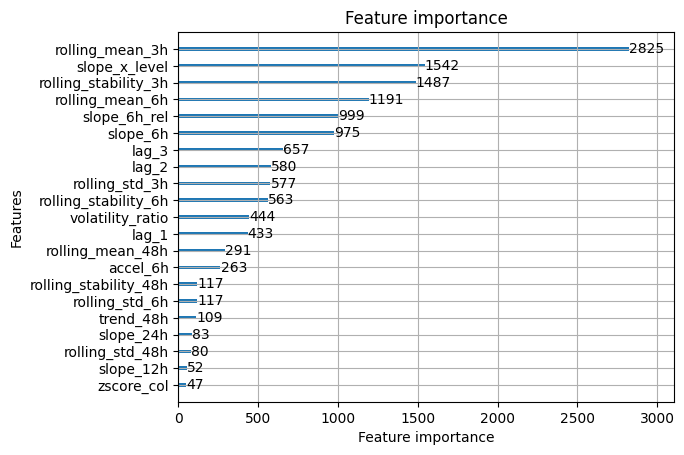

In [90]:
plot_importance(model)

Text(0, 0.5, '|Erreur|')

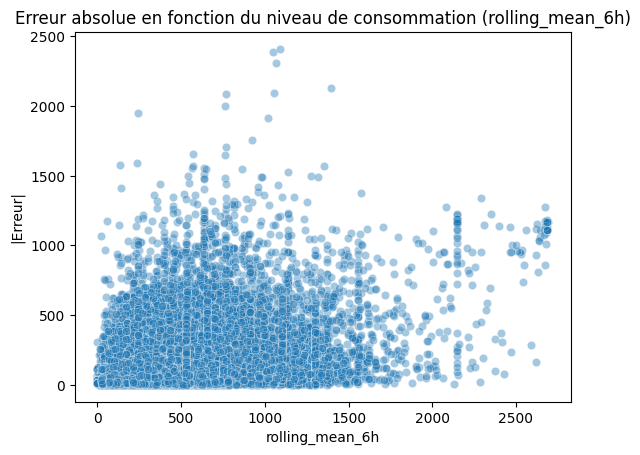

In [91]:
sns.scatterplot(x=X_v["rolling_mean_6h"], y=np.abs(y_v.y_true.values - y_pred), alpha=0.4)
plt.title("Erreur absolue en fonction du niveau de consommation (rolling_mean_6h)")
plt.xlabel("rolling_mean_6h")
plt.ylabel("|Erreur|")


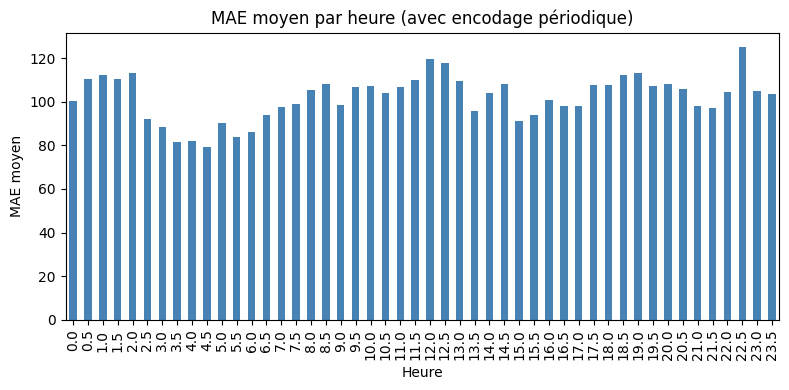

In [92]:
y_error = np.abs(y_v.y_true.values - y_pred)
tmp = X_v.copy()
tmp["error"] = y_error
tmp['hour'] = X_val['hour']

hourly_mae = tmp.groupby("hour")["error"].mean()
plt.figure(figsize=(8,4))
hourly_mae.plot(kind="bar", color="steelblue")
plt.title("MAE moyen par heure (avec encodage périodique)")
plt.xlabel("Heure")
plt.ylabel("MAE moyen")
plt.tight_layout()
plt.show()
